EDA

In [1]:
import pandas as pd

# Cargar el archivo Excel

df_internet = pd.read_excel("E:/Henry/PI2/Excel/Internet.xlsx", sheet_name=None)


Cargo el excel, reviso las hojas del mismo, dimensiones, duplicados, tipos de datos y valores nulos

In [2]:
import seaborn as sns


# Obtener los nombres de las hojas
sheet_names = df_internet.keys()

# Función para realizar inspección inicial de cada hoja
def inspeccion_inicial(df):
    print("Dimensiones:", df.shape)
    print("Tipos de datos:", df.dtypes)
    print("Primeras filas:", df.head())
    print("Últimas filas:", df.tail())
    print("Valores faltantes:", df.isnull().sum())
    print("Duplicados:", df.duplicated().sum())

# Realizar inspección inicial para cada hoja
for sheet_name in sheet_names:
    print(f"Hoja: {sheet_name}")
    df = df_internet[sheet_name]
    inspeccion_inicial(df)
    print("\n")

    # Resumen estadístico
    print(df.describe())
    print("\n")


Hoja: Acc_vel_loc_sinrangos
Dimensiones: (3065, 125)
Tipos de datos: Provincia      object
Partido        object
Localidad      object
Link Indec     object
Otros         float64
               ...   
999 Mbps      float64
1000 Mbps     float64
1024 Mbps     float64
4000 Mbps     float64
10000 Mbps    float64
Length: 125, dtype: object
Primeras filas:       Provincia     Partido          Localidad Link Indec  Otros  0,256 Mbps  \
0  BUENOS AIRES  25 de Mayo         25 de Mayo    6854100    NaN         NaN   
1  BUENOS AIRES  25 de Mayo    Agustín Mosconi    6854010    NaN         NaN   
2  BUENOS AIRES  25 de Mayo          Del Valle    6854020    NaN         NaN   
3  BUENOS AIRES  25 de Mayo          Ernestina    6854030    NaN         NaN   
4  BUENOS AIRES  25 de Mayo  Gobernador Ugarte    6854040    NaN         NaN   

   0,5 Mbps  0,512 Mbps  0,75 Mbps  1 Mbps  ...  680 Mbps  700 Mbps  800 Mbps  \
0       2.0         NaN       19.0     NaN  ...       NaN       NaN       NaN   
1  

Las variables se encuentran en un formato adecuado para ser usadas
Noto que se encuentran muchos valores en NaN en varias de las hojas del excel, estos valores no los cambiaria porque si no me darian mal las graficas.
Hay un error en una de las columnas de año (2033), parece ser un error que corregi como 2023 ya que se encontraba ubicado dentro de esos años

Inicio con los graficos y estudio del datasets para entender mejor su composicion

Al revisar los datos de la velocidad de internet en los años se nota que se ha mantenido la velocidad a nivel nacional

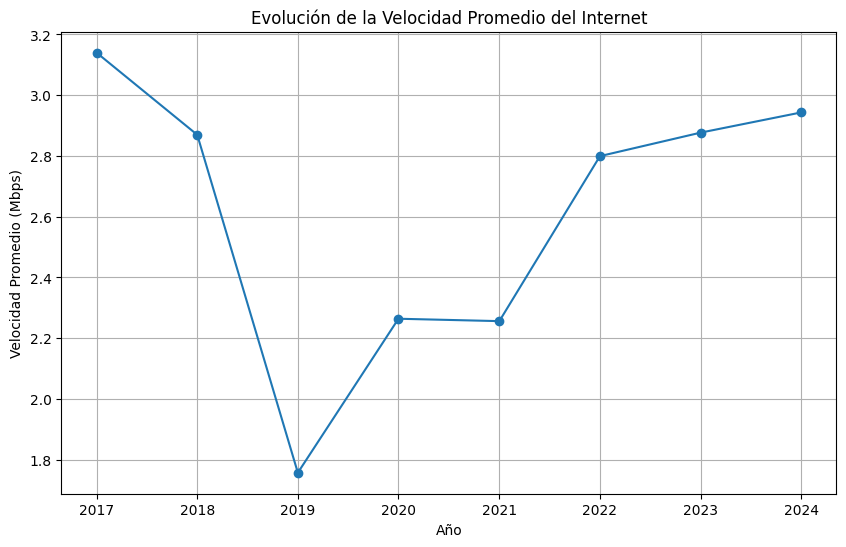

In [3]:
import matplotlib.pyplot as plt

# Acceder a la hoja específica "Velocidad_sin_Rangos"
df_velocidad = df_internet["Velocidad_sin_Rangos"]

# Convertir los nombres de las columnas de velocidades a un formato consistente
df_velocidad.columns = df_velocidad.columns.str.replace(' ', '')

# Transformar el DataFrame a formato largo (long format)
df_melted = df_velocidad.melt(id_vars='Año', var_name='Velocidad_Mbps', value_name='Cantidad')

# Convertir el año a datetime
df_melted['Año'] = pd.to_datetime(df_melted['Año'], format='%Y')

# Convertir la columna 'Velocidad_Mbps' a numérico, manejando errores
df_melted['Velocidad_Mbps'] = pd.to_numeric(df_melted['Velocidad_Mbps'].str.replace(',', '.').str.extract('(\d+\.\d+)')[0], errors='coerce')

# Asegurarse de que 'Cantidad' sea numérico
df_melted['Cantidad'] = pd.to_numeric(df_melted['Cantidad'], errors='coerce')

# Omitir NaN en los cálculos
df_melted = df_melted.dropna()

# Agrupar por año y calcular la velocidad promedio ponderada por la cantidad
df_agrupado = df_melted.groupby('Año').apply(lambda x: (x['Velocidad_Mbps'] * x['Cantidad']).sum() / x['Cantidad'].sum()).reset_index()
df_agrupado.columns = ['Año', 'Velocidad_Promedio_Mbps']

# Crear el gráfico de la evolución de la velocidad
plt.figure(figsize=(10, 6))
plt.plot(df_agrupado['Año'], df_agrupado['Velocidad_Promedio_Mbps'], marker='o', linestyle='-')
plt.title("Evolución de la Velocidad Promedio del Internet")
plt.xlabel("Año")
plt.ylabel("Velocidad Promedio (Mbps)")
plt.grid(True)
plt.show()


Con este nuevo grafico reviso la distribucion de la tecnologia a nivel Argentina siendo que la opcion mas utilizada es cablemodem seguida por la fibra optica

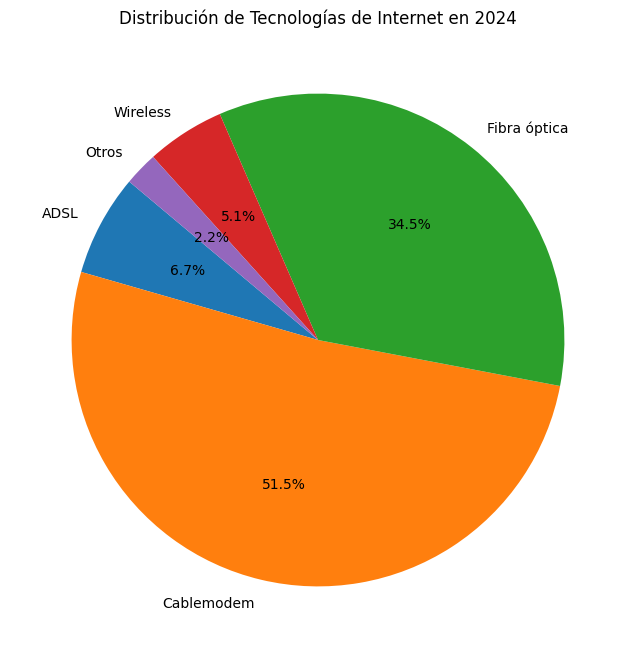

In [4]:
df_tecnologia = df_internet["Accesos Por Tecnología"]
# Filtrar el DataFrame para el año 2024
df_2024 = df_tecnologia[df_tecnologia['Año'] == 2024]

# Sumar todas las tecnologías a nivel país
tecnologias = df_2024[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']].sum()

# Crear el gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(tecnologias, labels=tecnologias.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Tecnologías de Internet en 2024')
plt.show()


Al revisar los datos de cada provincia podemos notar que cada año va pasando de tecnologias antiguas a mas modernas como es la fibra optica o cablemodem
En provincias mas chicas (menos cantidad de habitantes) se nota que aumenta bastante mas rapido el paso a fibra optica

Se notan algunos outlayers en ciertos trimestres como en la provincia de Formosa en el año 2022

In [5]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import re

# Acceder a la hoja específica "Accesos Por Tecnología"
df_tecnologia = df_internet["Accesos Por Tecnología"]

# Limpiar la columna "Año" para que contenga solo valores numéricos
df_tecnologia['Año'] = df_tecnologia['Año'].apply(lambda x: re.sub(r'\D', '', str(x)))

# Convertir la columna "Año" a numérico
df_tecnologia['Año'] = pd.to_numeric(df_tecnologia['Año'], errors='coerce')

# Convertir las columnas de tecnologías a numérico, reemplazando los valores no convertibles por NaN
for col in ['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']:
    df_tecnologia[col] = pd.to_numeric(df_tecnologia[col], errors='coerce')

# Crear el desplegable para seleccionar la provincia
provincias = df_tecnologia['Provincia'].unique().tolist()
dropdown = widgets.Dropdown(
    options=provincias,
    description='Provincia:',
    disabled=False,
)

# Función para actualizar el gráfico
def actualizar_grafico(provincia):
    plt.figure(figsize=(10, 6))
    df_provincia = df_tecnologia[df_tecnologia['Provincia'] == provincia]
    
    for tecnologia in ['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']:
        plt.plot(df_provincia['Año'], df_provincia[tecnologia], marker='o', label=tecnologia)
    
    plt.title(f"Evolución de Tecnologías en {provincia}")
    plt.xlabel("Año")
    plt.ylabel("Cantidad de Usuarios")
    plt.legend()
    plt.grid(True)
    plt.show()

# Vincular la función de actualización al cambio de valor en el desplegable
output = widgets.interactive_output(actualizar_grafico, {'provincia': dropdown})

# Mostrar el desplegable y el gráfico
display(dropdown, output)


Dropdown(description='Provincia:', options=('Buenos Aires', 'Capital Federal', 'Catamarca', 'Chaco', 'Chubut',…

Output()

Se nota una evolucion en la descarga del internet durante los años, que queda en evidencia la mejora en la llegada de internet a los clientes

La ultima parte del 2024 se ve una bajada de la velocidad pero eso es porque todavia no hay datos

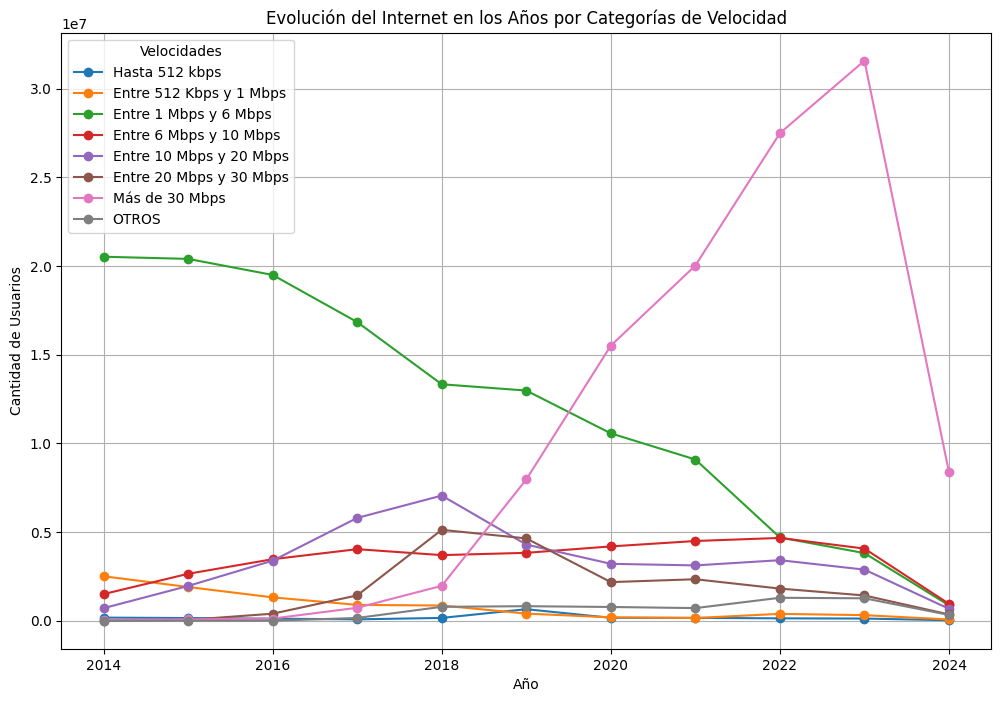

In [6]:
import matplotlib.pyplot as plt

df_velocidad2 = df_internet["Totales Accesos por velocidad"]

# Sumar las velocidades en cada año para obtener el total por categoría de velocidad
df_agrupado = df_velocidad2.groupby('Año').sum().reset_index()

# Crear la gráfica
plt.figure(figsize=(12, 8))

# Lista de categorías de velocidad
velocidades = [
    'Hasta 512 kbps', 'Entre 512 Kbps y 1 Mbps', 'Entre 1 Mbps y 6 Mbps', 
    'Entre 6 Mbps y 10 Mbps', 'Entre 10 Mbps y 20 Mbps', 'Entre 20 Mbps y 30 Mbps', 
    'Más de 30 Mbps', 'OTROS'
]

# Graficar cada categoría de velocidad
for velocidad in velocidades:
    plt.plot(df_agrupado['Año'], df_agrupado[velocidad], marker='o', label=velocidad)

plt.title("Evolución del Internet en los Años por Categorías de Velocidad")
plt.xlabel("Año")
plt.ylabel("Cantidad de Usuarios")
plt.legend(title="Velocidades")
plt.grid(True)
plt.show()


En el mapa de la velocidad promedio por provincias podemos ver que las provincias con mejor internet es Buenos Aires, Caba, Cordoba y San Luis. Por otro lado se nota que hay provincias que siguen muy atrasadas en los avances del internet como es San Juan, La Pampa y las provincias de mas al sur del pais

C:\Users\Federico\AppData\Local\Temp\ipykernel_21024\3446538612.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(gdf_provincias.geometry.centroid.x, gdf_provincias.geometry.centroid.y, gdf_provincias['Provincia']):


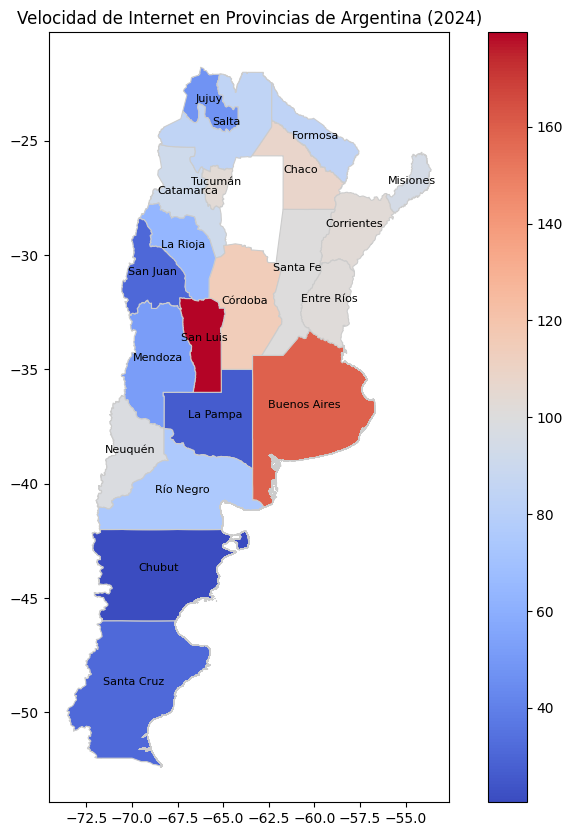

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

df_mapa = df_internet["Velocidad % por prov"]

# Ruta al archivo .shp dentro de la carpeta descargada y extraída
shapefile_path = 'E:/Henry/PI2/gadm41_ARG_1.shp'

# Cargar el shapefile
gdf_provincias = gpd.read_file(shapefile_path)

# Filtrar los datos para que solo contengan el año 2024
df_mapa_2024 = df_mapa[df_mapa['Año'] == 2024]

# Supongamos que el campo de provincias en el shapefile es 'NAME_1'
gdf_provincias = gdf_provincias.merge(df_mapa_2024, left_on='NAME_1', right_on='Provincia')


# Crear el gráfico del mapa
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_provincias.plot(column='Mbps (Media de bajada)', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Añadir los nombres de las provincias
for x, y, label in zip(gdf_provincias.geometry.centroid.x, gdf_provincias.geometry.centroid.y, gdf_provincias['Provincia']):
    ax.annotate(text=label, xy=(x, y), ha='center', fontsize=8, color='black')

# Configurar el título del gráfico
plt.title('Velocidad de Internet en Provincias de Argentina (2024)')
plt.show()


KPI